# Integrator comparisons for N-body problem

Yuri Shimane, 2024.03.08

In [132]:
using Pkg
Pkg.status()

Project FullEphemerisPropagator v0.1.0
Status `~/Documents/codes/dev-jl/FullEphemerisPropagator.jl/Project.toml`
⌃ [e9467ef8] GLMakie v0.9.8
  [7073ff75] IJulia v1.24.2
⌃ [1dea7af3] OrdinaryDiffEq v6.70.1
  [5bab7191] SPICE v0.2.3
  [d1185830] SymbolicUtils v1.5.0
⌃ [0c5d862f] Symbolics v5.16.1
  [37e2e46d] LinearAlgebra
  [de0858da] Printf
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [403]:
using GLMakie
using SPICE
using OrdinaryDiffEq
using BenchmarkTools
using ProgressMeter
using LinearAlgebra

In [404]:
include(joinpath(@__DIR__, "../src/FullEphemerisPropagator.jl"))

Main.FullEphemerisPropagator

In [405]:
# furnish spice kernels
spice_dir = ENV["SPICE"]

# get spice kernels
furnsh(joinpath(spice_dir, "lsk", "naif0012.tls"))
furnsh(joinpath(spice_dir, "spk", "de440.bsp"))

# define parameters
mus = [
    4.9028000661637961E+03,
    3.9860043543609598E+05,
    1.3271244004193938E+11,
]
naif_ids = ["301", "399", "10"]
naif_frame = "J2000"
abcorr = "NONE"
lstar = 3000.0

3000.0

In [406]:
# initial epoch and state of an NRHO (almost) in canonical scales using LU = 3000 km
et0 = 946728069.3271508
state0 = [-0.03344377115230989, 5.7624151996473545, -22.743438743043676, 
          -0.046526421787245704, 0.029709480647552224, 0.004309142532513644]

6-element Vector{Float64}:
  -0.03344377115230989
   5.7624151996473545
 -22.743438743043676
  -0.046526421787245704
   0.029709480647552224
   0.004309142532513644

In [407]:
# instantiate propagator
prop = FullEphemerisPropagator.Propagator(
    Vern8(),
    lstar,
    mus,
    naif_ids;
    use_srp = true,
    naif_frame = naif_frame,
    reltol = 1e-14,
    abstol = 1e-12,
);

In [408]:
prop.parameters.vstar, sqrt(mus[1]/lstar)

(1.2783844056938685, 1.2783844056938685)

In [409]:
R_LLO = 1737.4 + 1000.0
state0_llo = [R_LLO/lstar, 0.0, 0.0,
          0.0, 0.0, sqrt(1.0/(R_LLO/lstar))]

sqrt(mus[1]/R_LLO), sqrt(1.0/(R_LLO/lstar)) * prop.parameters.vstar

(1.3382984044425965, 1.3382984044425965)

In [410]:
# test solve
tspan = (0.0, FullEphemerisPropagator.sec2TU(prop, 30 * 86400))
sol = FullEphemerisPropagator.propagate(prop, et0, tspan, state0_llo)
@show sol.u[end];

sol.u[end] = [-0.348395990173016, 0.003872555058765745, -0.843273052107238, 0.9675104102431507, -0.010791679793158666, -0.3998144986692881]


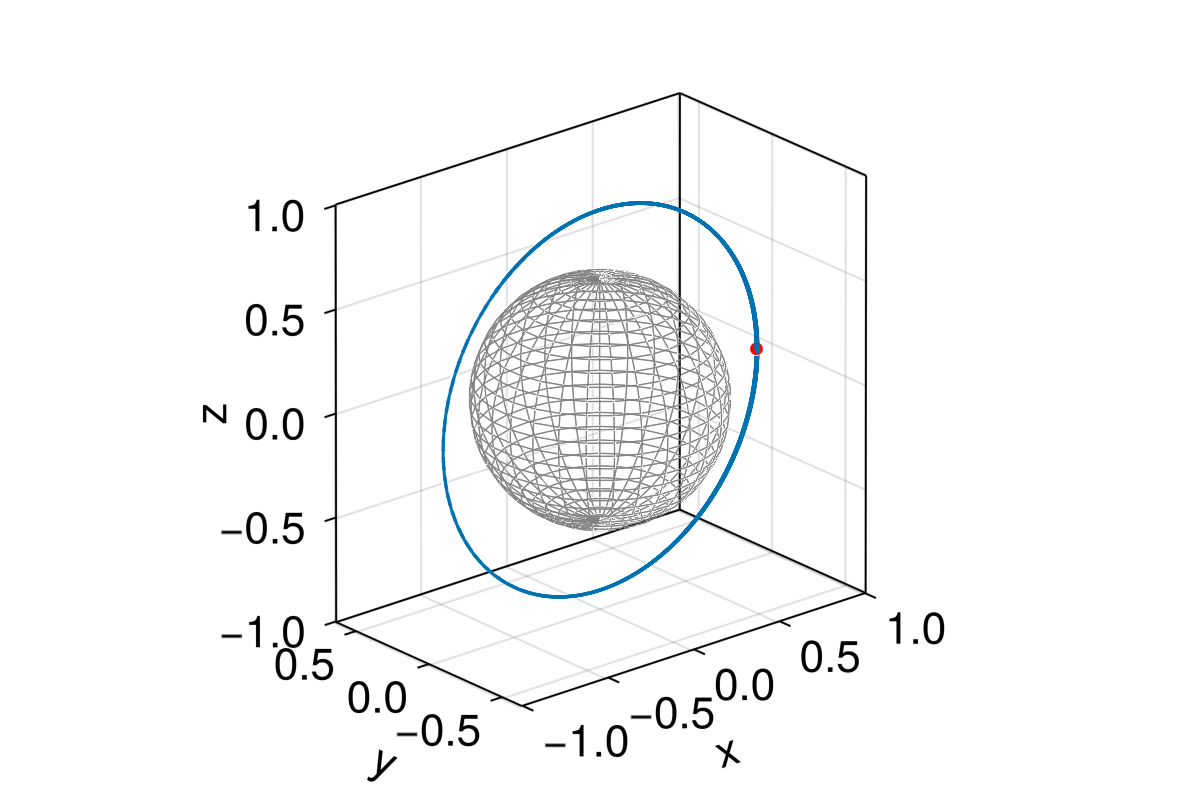

In [412]:
# plot with GLMakie
fig = Figure(size=(600,400), fontsize=22)
ax1 = Axis3(fig[1, 1], aspect=:data)
scatter!(ax1, sol[1,1], sol[2,1], sol[3,1], color=:red)
lines!(ax1, sol[1,:], sol[2,:], sol[3,:])

# Generate points on the sphere
nsph = 30
θ = range(0, stop=2π, length=nsph)
ϕ = range(0, stop=π, length=nsph)
R = 1737.4/lstar
center = [0, 0, 0]
xsphere = [center[1] + R * cos(θ[i]) * sin(ϕ[j]) for j in 1:nsph, i in 1:nsph]
ysphere = [center[2] + R * sin(θ[i]) * sin(ϕ[j]) for j in 1:nsph, i in 1:nsph]
zsphere = [center[3] + R * cos(ϕ[j]) for j in 1:nsph, i in 1:nsph]
wireframe!(ax1, xsphere, ysphere, zsphere, color=:grey, linewidth=0.5)
fig

## 1. Speed comparison

We first conduct a benchmark test on the integrator speed.

We consider the following methods

**7-th order RK**
- `Vern7` - Verner's “Most Efficient” 7/6 Runge-Kutta method. (lazy 7th order interpolant).
- `TanYam7` - Tanaka-Yamashita 7 Runge-Kutta method.

**8-th order RK**
- `Vern8` - Verner's “Most Efficient” 8/7 Runge-Kutta method. (lazy 8th order interpolant)
- `TsitPap8` - Tsitouras-Papakostas 8/7 Runge-Kutta method
- `DP8` - Hairer's 8/5/3 adaption of the Dormand-Prince Runge-Kutta method. (7th order interpolant).

**9-th order RK**
- `Vern9` - Verner's “Most Efficient” 9/8 Runge-Kutta method. (lazy 8th order interpolant)

In [314]:
methods = [Vern7(), TanYam7(),            # RK 7
           Vern8(), TsitPap8(), DP8(),    # RK 8(7) methods
           Vern9(),                       # RK 9(8) methods                  
]
bruns = []
tspan = (0.0, FullEphemerisPropagator.sec2TU(prop, 30 * 86400))

@showprogress for method in methods
    # mutate method of propagator
    prop.method = method
    
    # dry run once to ensure it is pre-compiled
    FullEphemerisPropagator.propagate(prop, et0, tspan, state0);
    
    # run benchmark
    #FullEphemerisPropagator.pretty(prop)
    b = @benchmarkable FullEphemerisPropagator.propagate($prop, $et0, $tspan, $state0);
    tune!(b);
    push!(bruns, run(b))
end
println("Done!")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


Done!


In [315]:
bruns[1]

BenchmarkTools.Trial: 126 samples with 1 evaluation.
 Range (min … max):  36.357 ms … 57.684 ms  ┊ GC (min … max): 0.00% … 33.01%
 Time  (median):     37.920 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   39.785 ms ±  4.608 ms  ┊ GC (mean ± σ):  4.82% ±  8.88%

    █▄ ▃                                                       
  ▃▄██▆███▄▄▁▃▁▁▃▁▁▃▁▁▃▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▄▃▄▃▁▁▁▁▁▃▁▃ ▃
  36.4 ms         Histogram: frequency by time        52.3 ms <

 Memory estimate: 27.19 MiB, allocs estimate: 511210.

In [316]:
[length(brun.times) for brun in bruns]

6-element Vector{Int64}:
 126
 146
 201
 189
 164
 191

## 2. Accuracy comparison

We now conduct test on the accuracy. Since we do not have a "truth" trajectory, we take an initial state, propagate forward by some $\Delta t$, then propagate the final state backward by $-\Delta t$, and compare the final, backpropagated state to the initial state; this quantity is effectively twice the accumulated integration error from integrating a duration of $|\Delta t|$.

In [317]:
function forwardbackward(et0, tf, x0)
    # 1. propagate forward
    sol_fwd = FullEphemerisPropagator.propagate(prop, et0, (0.0, tf), x0);
    # 2. propagate backward
    etf = et0 + FullEphemerisPropagator.TU2sec(prop, tf)
    sol_bck = FullEphemerisPropagator.propagate(prop, etf, (0.0, -tf), sol_fwd.u[end]);
    # compute error
    error = sol_bck.u[end] - x0
    return error, sol_fwd, sol_bck
end

forwardbackward (generic function with 1 method)

In [327]:
tf = FullEphemerisPropagator.sec2TU(prop, 30 * 86400)
errors = []
n_timesteps = Int[]

@showprogress for method in methods
    # mutate method of propagator
    prop.method = method

    # run forward-backward test
    error, sol_fwd, _ = forwardbackward(et0, tf, state0)
    push!(errors, [norm(error[1:3]), norm(error[4:6])])
    push!(n_timesteps, length(sol_fwd.t))
end
errors = hcat(errors...)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


2×6 Matrix{Float64}:
 6.76882e-10  4.32786e-8   8.50751e-10  2.45416e-9   3.44377e-9   7.60117e-10
 1.10294e-11  7.28396e-10  1.59888e-11  3.83759e-11  4.54104e-11  1.18021e-11

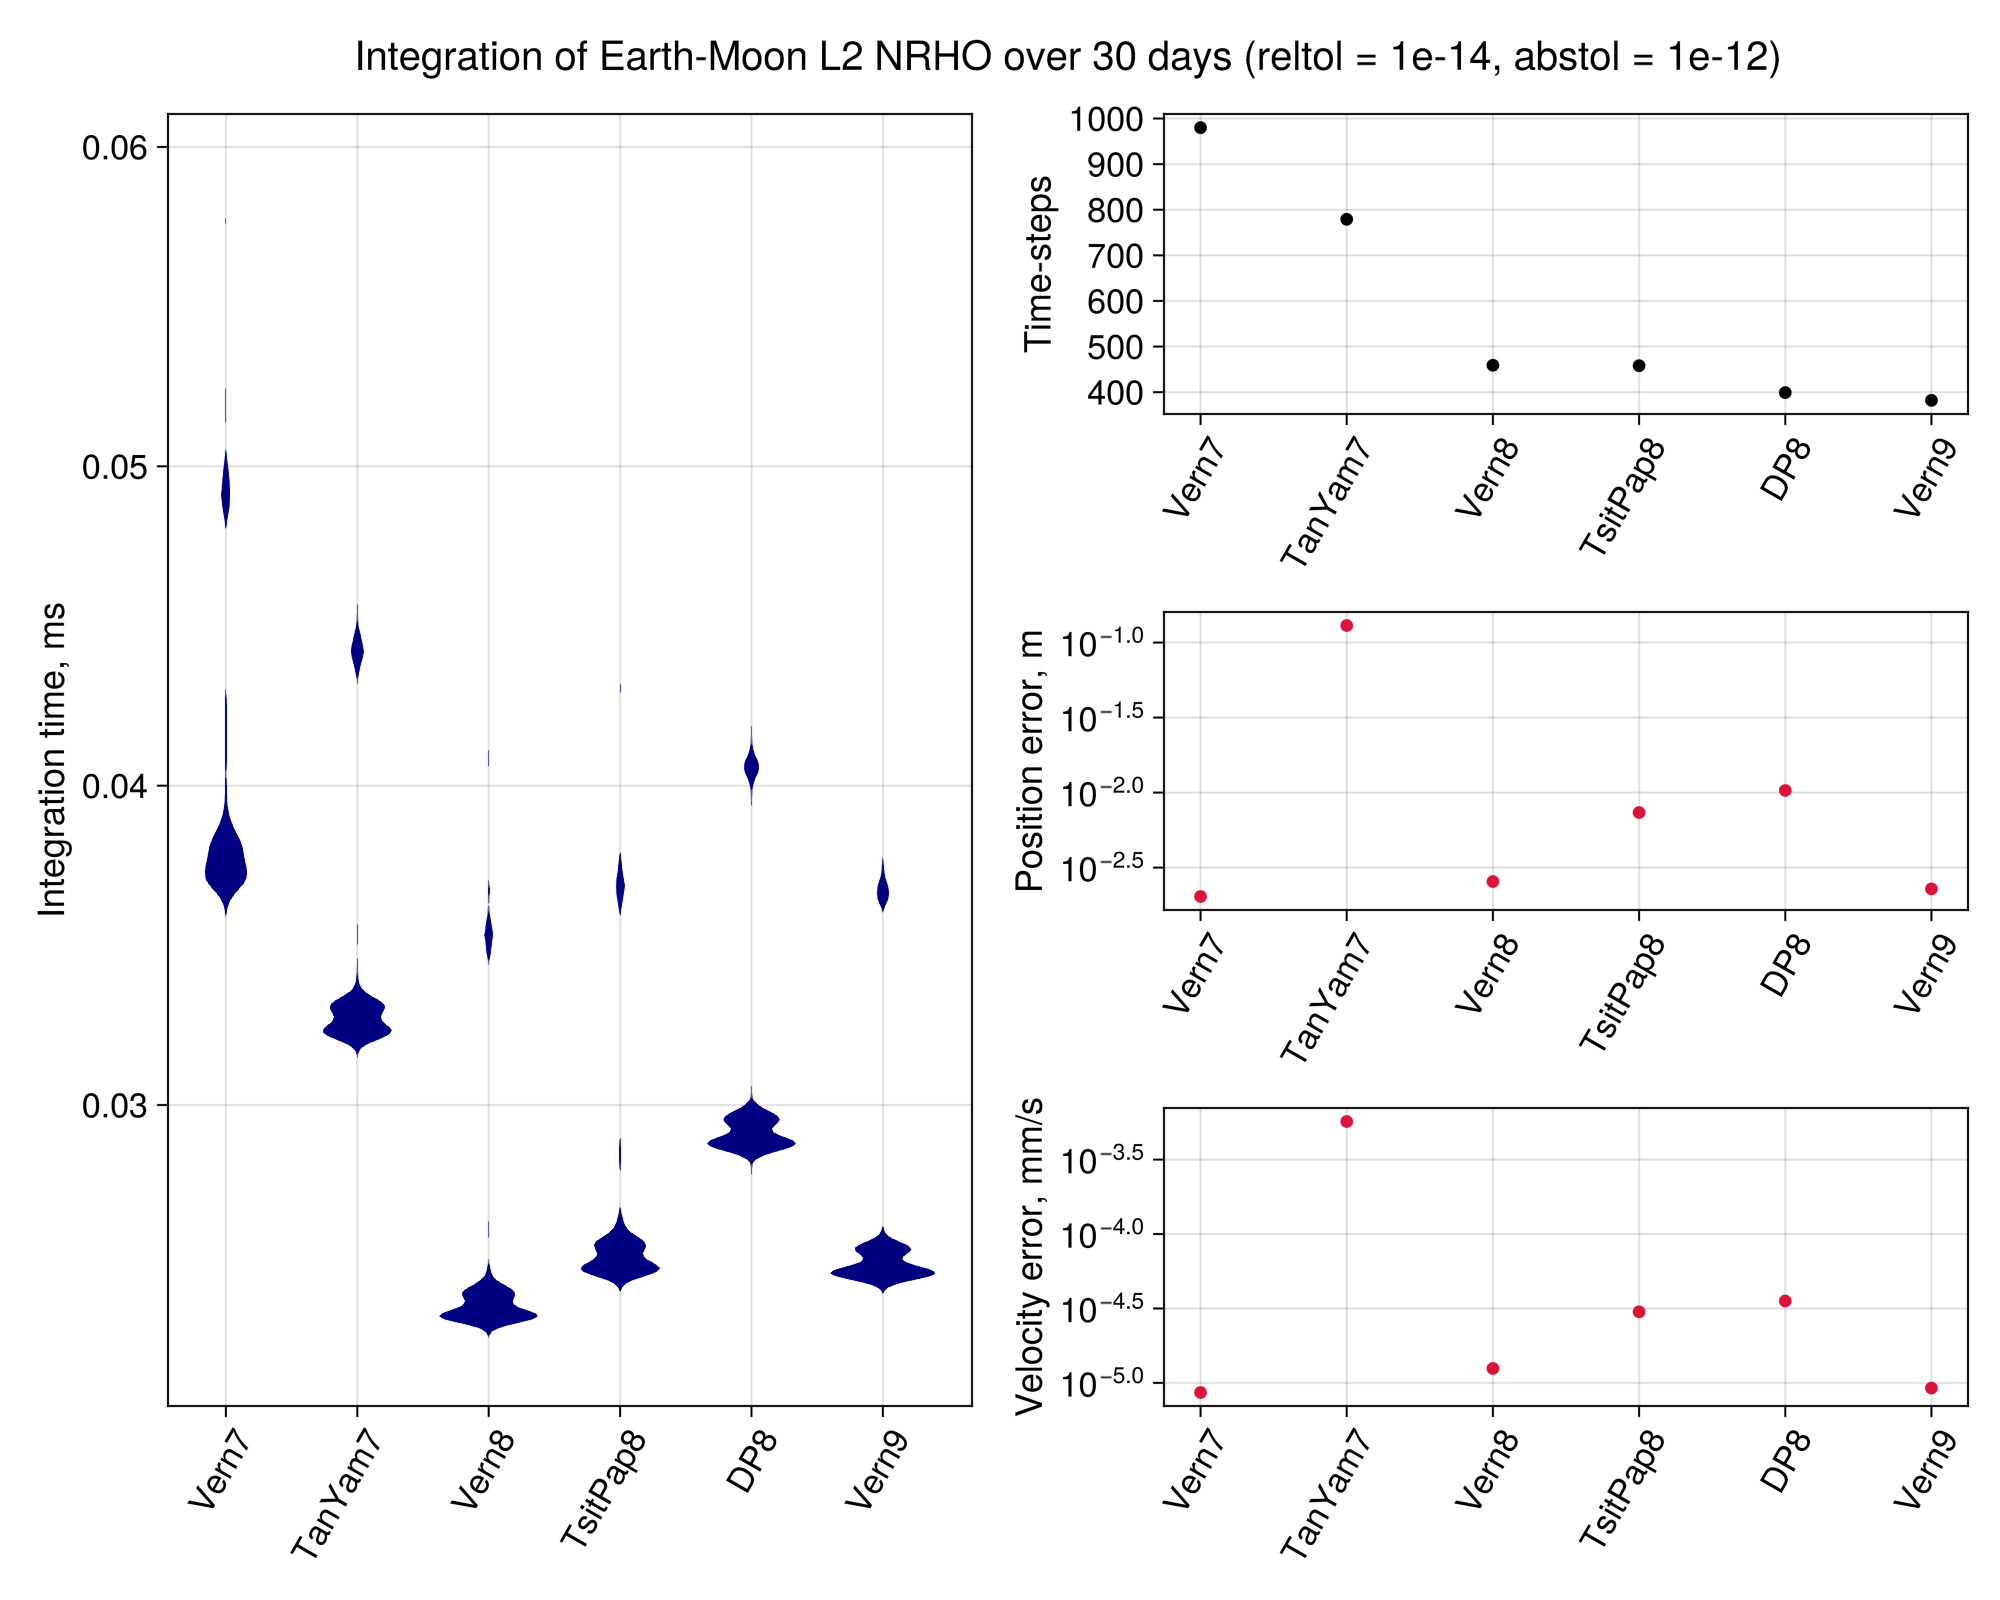

In [333]:
fontsize = 18
names = [split(string(method), "(;")[1] for method in methods]
fig = Figure(size=(1000,800))

xlabelrot = 60

# make histogram of times
ax = Axis(fig[1:3,1];
    ylabel = "Integration time, ms", xticks = (1:length(names), names),
    xticklabelrotation = deg2rad(xlabelrot),
    titlesize=fontsize, xlabelsize=fontsize, ylabelsize=fontsize, xticklabelsize=fontsize-1, yticklabelsize=fontsize-1,
)
categories = vcat([[idx for _ in 1:length(brun.times)] for (idx,brun) in enumerate(bruns)]...,)
values = vcat([brun.times/1e9 for brun in bruns]...)
violin!(ax, categories, values, color=:navy)

# make scatters of number of time-steps taken
ax = Axis(fig[1,2];
    ylabel = "Time-steps", xticks = (1:length(names), names), #yscale = log10,
    xticklabelrotation = deg2rad(xlabelrot),
    titlesize=fontsize, xlabelsize=fontsize, ylabelsize=fontsize, xticklabelsize=fontsize-1, yticklabelsize=fontsize-1,
)
scatter!(ax, 1:length(names), n_timesteps, color=:black)

# make scatter of errors
ax = Axis(fig[2,2];
    ylabel = "Position error, m", xticks = (1:length(names), names), yscale = log10,
    xticklabelrotation = deg2rad(xlabelrot),
    titlesize=fontsize, xlabelsize=fontsize, ylabelsize=fontsize, xticklabelsize=fontsize-1, yticklabelsize=fontsize-1,
)
scatter!(ax, 1:length(names), errors[1,:] * prop.parameters.lstar * 1e3, color=:crimson)

ax = Axis(fig[3,2];
    ylabel = "Velocity error, mm/s", xticks = (1:length(names), names), yscale = log10,
    xticklabelrotation = deg2rad(xlabelrot),
    titlesize=fontsize, xlabelsize=fontsize, ylabelsize=fontsize, xticklabelsize=fontsize-1, yticklabelsize=fontsize-1,
)
scatter!(ax, 1:length(names), errors[2,:] * prop.parameters.vstar * 1e6, color=:crimson)

supertitle = Label(fig[0,:], "Integration of Earth-Moon L2 NRHO over 30 days (reltol = 1e-14, abstol = 1e-12)", fontsize = fontsize+2)
fig